In [1]:
from IPython.display import display, Math, Latex, Image

In [2]:
import numpy as np
import theano
import theano.tensor as T
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

On traitera la base de données MNIST

In [3]:
from mnist import MNIST

mndata = MNIST('/Users/Doudou/Documents/Scolarité/PHD/Travail en amont')
images, labels = mndata.load_training()


In [4]:
index = 17
print(mndata.display(images[index]))


............................
............................
............................
............................
............................
....................@@......
....................@@......
...............@@@..@.......
............@@@@.@@@@.......
...........@@.....@@@.......
...........@@.....@@........
...........@@....@@.........
............@@.@@@..........
............@@@@@...........
............@@@@............
............@@@.............
...........@@@@.............
..........@@@.@.............
.........@@...@.............
........@@...@@.............
........@....@@.............
........@...@@..............
........@..@@...............
........@@@@................
.........@..................
............................
............................
............................


References:

• http://www.iro.umontreal.ca/~bengioy/ift6266/H14/ftml-sec5.pdf

• http://www.ee.nthu.edu.tw/hchen/pubs/iee2003.pdf

• https://arxiv.org/pdf/1309.3103.pdf

• http://www-etud.iro.umontreal.ca/~boulanni/ICML2012.pdf

RBM are generative models asuming all-to-all symmetric connectivity between $ N $ visible and $ M $ hidden variables. It seeks to model the structure of a given dataset. RBM is an energy-based model parametrized by a $ N \times M $ dimensional weight matrix $ W $, a bias $ b^h $ for the hidden variable and a bias $ b^v $ for the visible variable.

Energy function is defined with linear connections and no interconnections of respectively hidden and visible layer members:

$$ E(v,h \ | \ W,b^v,b^h)=-\sum_{i,j}{W_ij v_i h_j} - \sum_i{b_i^v v_i} - \sum_{j}{b_j^h h_j} $$

and the probability of a specific configuration $ (v,h) $ is given by:

$$ P(v,h) = \frac{e^{-E(v,h| W,b^v,b^h)}}{Z(W,b^v,b^h)} $$


The free-energy function is then defined as:

$$ \mathcal{F}(v) = -b^Tv - \sum_i{log \sum_{h_i} e^{h_i(c_i+W_iv)}}$$

Remark: the respective independence of hidden units and visible units allows the model efficient in sampling and enables exact computation of distribution parameters


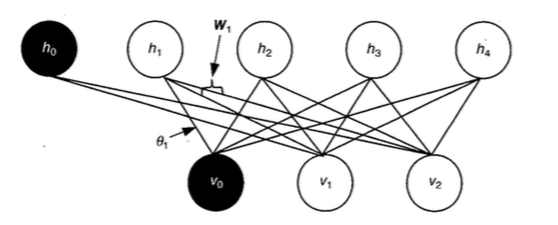

In [5]:
Image("/Users/Doudou/Desktop/RBM.png")

In [747]:
class RBM(object):
    
    def __init__(self, 
                 n_visible,
                 n_hidden, 
                 W=None, 
                 h_bias = None, 
                 v_bias = None):
        
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        #r = np.random.RandomState(1234)
        r = np.random
        self.r = r
        
        if W is None: 
            W = np.asarray(r.uniform(low=-0.1 * np.sqrt(6. / (n_hidden + n_visible)), 
                                     high=0.1 * np.sqrt(6. / (n_hidden + n_visible)), 
                                     size=(n_visible, n_hidden)), dtype = float)
        
        if h_bias is None:
            h_bias = np.zeros(n_hidden, dtype = float)
            
        if v_bias is None:
            v_bias = np.zeros(n_visible, dtype = float)
            
        self.W = W
        self.h_bias = h_bias
        self.v_bias = v_bias
        self.rng = r
        self.params = [self.W, self.h_bias, self.v_bias]
        

If the input variables and hidden units are both binary, we compute:

$ P(v_i = 1|h) = \sigma(\sum_j{W_{ij}h_j + b_j^v}) $

$ P(h_j = 1|v) = \sigma(\sum_i{W_{ij}v_i + b_j^h)} $



In [759]:
def pre_sampling_hidden(self, prev_vis):
    pre_act = np.dot(prev_vis, self.W)+self.h_bias
    proba_h = sp.special.expit(pre_act)
    return [pre_act, proba_h]

RBM.pre_sampling_hidden = pre_sampling_hidden

def pre_sampling_visible(self, cur_hidden):
    pre_act = np.dot(cur_hidden, self.W.T)+self.v_bias
    proba_v = sp.special.expit(pre_act)
    return [pre_act, proba_v]

RBM.pre_sampling_visible = pre_sampling_visible

def h_sample_from_v(self, prev_vis):
    pre_act, proba_binomial = self.pre_sampling_hidden(prev_vis)
    h_sample = np.random.binomial(size = proba_binomial.shape, n = 1, p = proba_binomial)
    return [pre_act, proba_binomial, h_sample]

RBM.h_sample_from_v = h_sample_from_v

def v_sample_from_h(self, cur_hidden):
    pre_act, proba_binomial = self.pre_sampling_visible(cur_hidden)
    v_sample = np.random.binomial(size = proba_binomial.shape, n = 1, p = proba_binomial)
    return [pre_act, proba_binomial, v_sample]

RBM.v_sample_from_h = v_sample_from_h


The sampling of the variables is made by Gibbs sampling. GS of the $ N $ joint random variables $ (S_i)_{i=1}^N $ is done with $ N $ sampling substeps of the form $ S_i \sim p(S_i | S_{-i}) $. In our case, the visible and hidden variables are conditionnaly independent, then we adapt the GS such that values are fixed simultaneoulsy:

• $ h_{n+1} \sim \sigma(W^T v_n + b^h) $

• $ v_{n+1} \sim \sigma(W h_{n+1} + b^v) $

In [760]:
def gs_hvh(self, init_h_sample):
    
    pre_act_v, v_proba, v_sample = self.v_sample_from_h(init_h_sample)
    pre_act_h, h_proba, h_sample = self.h_sample_from_v(v_sample)
    
    return [pre_act_v, v_proba, v_sample, 
            pre_act_h, h_proba, h_sample]

RBM.gs_hvh = gs_hvh

def gs_vhv(self, init_v_sample):
    
    pre_act_h, h_proba, h_sample = self.h_sample_from_v(init_v_sample)
    pre_act_v, v_proba, v_sample = self.v_sample_from_h(h_sample)
    
    return [pre_act_h, h_proba, h_sample,
            pre_act_v, v_proba, v_sample]

RBM.gs_vhv = gs_vhv


Contrastive Divergence with $ k $ steps is a trick-added version of GS that speeds up the process, based on two assumptions:

• we want $ p(v) \approx p_{train}(v) $ and we then initialize the chain with training example

• CD does not let the process converging, from empirical observations of great results with only $ k $ steps, with $ k << \infty $

More informations here: http://www.robots.ox.ac.uk/~ojw/files/NotesOnCD.pdf


The derivatives of the log-likelihood of an observed visible state v is:

$$ \frac{\partial log \ P(v)}{\partial \theta} = -\frac{\partial \mathcal{F}(v)}{\partial \theta} + \sum_{v'}{P(v') \frac{\partial \mathcal{F}(v')}{\partial \theta}} = -\Bigg \langle\ \frac{\partial E}{\partial \theta} \mid v \Bigg \rangle_h + \Bigg \langle\ \frac{\partial E}{\partial \theta} \Bigg \rangle_{v,h} \ (1) $$

And:

• $ \frac{\partial E(v,h \ | \ W,b^v,b^h)}{\partial W_{ij}}=-v_i h_j $

• $ \frac{\partial E(v,h \ | \ W,b^v,b^h)}{\partial b_{j}}=-h_j $

• $ \frac{\partial E(v,h \ | \ W,b^v,b^h)}{\partial c_{i}}=-v_i $

then:

• $ -\Bigg \langle\ \frac{\partial E(v,h \ | \ W,b^v,b^h)}{\partial W_{ij}} \mid v \Bigg \rangle_h =-v_i P(h_j=1 \mid v) $

• etc...

#### The pseudo code of the CD-1 is:

I. for each training sample x(t):

• Sample hidden units from x(t)

• Compute outer product of input and hidden units $ \rightarrow $ positive phase

• Make GS step $ \rightarrow $ resample visible units from hidden then resample hidden from newly sampled visible units

• Compute outer product of those new units $ \rightarrow $ negative phase

• Update the weight by difference between "visible phase" and "negative phase" times learning rate

II. Do while stopping criteria unreached

For more explanation: https://www.youtube.com/watch?v=wMb7cads0go&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=40

In [761]:
def param_update(self, training_data, learning_rate, k=1):
    
    pre_act_h, proba_h, sample_h = self.h_sample_from_v(training_data)
    pos_phase = np.dot(training_data.T, proba_h)

    for i in np.arange(k):

        [pre_act_vk, vk_proba, vk_sample, 
          pre_act_hk, hk_proba, sample_h] = self.gs_hvh(sample_h)

    neg_phase = np.dot(vk_proba.T, hk_proba)
    
    self.W += learning_rate*(pos_phase-neg_phase)/len(training_data)
    
    for i in np.arange(len(training_data)):
        self.v_bias -= learning_rate*(training_data-vk_proba)[i,:]/len(training_data)
        self.h_bias -= learning_rate*(proba_h-hk_proba)[i,:]/len(training_data)

    return vk_proba

RBM.param_update = param_update


In [762]:
def free_energy(self, v_sample):
        a = np.dot(v_sample,self.v_bias)
        b = np.dot(v_sample, self.W) + self.h_bias
        c = np.sum(np.log(1+np.exp(b)))
        
        return (-a-c)
    
RBM.free_energy=free_energy

In [763]:
def train_rbm(self, training_data, learning_rate=0.01, max_steps=1000, k=1):
    
    error=[]
    free_energy=[]
    step=0 
    
    proba_v = self.param_update(training_data, learning_rate=0.01, k=k)[0]
    error.append(np.sum((training_data-proba_v)**2))
    free_energy.append(np.mean(self.free_energy(training_data)))
    
    while error[-1]>0.01 and step<max_steps:
        step+=1
        proba_v = self.param_update(training_data, learning_rate=learning_rate, k=k)
        error.append(np.sum((training_data-proba_v)**2))
        free_energy.append(np.mean(self.free_energy(training_data)))

    return error, free_energy

RBM.train_rbm = train_rbm


In [764]:
training_data = np.array(images[:100])
training_data=(training_data>0)*1

rbm = RBM(n_visible = 784, n_hidden = 500)

error, free = rbm.train_rbm(training_data, learning_rate=0.1, max_steps=1000)

28.6213535068


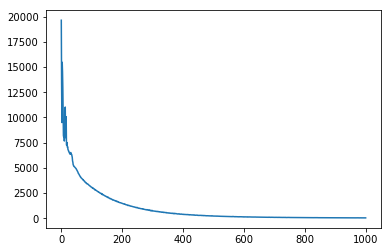

In [765]:
print(np.min(error))
plt.plot(error)


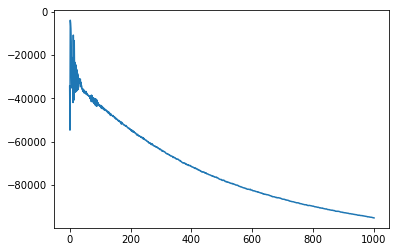

In [769]:
plt.plot((free))


We use cross-entropy as reconstruction cost to be minimized

In [19]:
def cross_entropy(self, p, q):
    return -np.mean(p*np.log(q)+(1-p)*(1-np.log(q)))

RBM.cross_entropy=cross_entropy
# we can also use:

from sklearn.metrics import log_loss


#### The extension of RBM to continous-values visible variable by modifying the energy function is gaussian-binary RBM:

$$ E(v,h|W,b^v,b^h,{\sigma_i}) = -\sum_{i,j}{\frac{W_ij v_i h_j}{\sigma_i^2}} + \sum_i{\frac{(b_i^v - v_i)^2}{2\sigma_i^2}} - \sum_j{b^h_j h_j} $$

We then obtain distributions for $ h $ and $ v $:

• $ P(v_i|h) = N(Wh + b_i^v, \sigma_i^2) $

• $ P(h_j|v) = \sigma(b_j^h + \frac{v^TW_{.j}}{\sigma_j})$

In [590]:
class GRBM(RBM):
    def __init__(self, 
                 n_visible,
                 n_hidden, 
                 sigma=1):
        
        self.sigma=sigma
        RBM.__init__(self, n_visible, n_hidden)
        

In [599]:
def pre_sampling_hidden(self, prev_vis):
    pre_act = np.dot(prev_vis, self.W)+self.h_bias
    return [pre_act, sp.special.expit(pre_act)]

GRBM.pre_sampling_hidden = pre_sampling_hidden

def pre_sampling_visible(self, cur_hidden):
    pre_act = np.dot(cur_hidden, self.W.T)+self.v_bias
    return [pre_act, sp.special.expit(pre_act)]

GRBM.pre_sampling_visible = pre_sampling_visible

def h_sample_from_v(self, prev_vis):
    pre_act, proba_binomial = self.pre_sampling_hidden(prev_vis)
    h_sample = np.random.binomial(size = proba_binomial.shape, n = 1, p = proba_binomial)
    return [pre_act, proba_binomial, h_sample]

GRBM.h_sample_from_v = h_sample_from_v

def v_sample_from_h(self, cur_hidden):
    pre_act, proba_binomial = self.pre_sampling_visible(cur_hidden)
    v_sample = (pre_act+sp.stats.norm.rvs(size=proba_binomial.shape))*self.sigma

    return [pre_act, proba_binomial, v_sample]

GRBM.v_sample_from_h = v_sample_from_h



In [ ]:
def gs_hvh(self, init_h_sample):
    
    pre_act_v, v_proba, v_sample = self.v_sample_from_h(init_h_sample)
    pre_act_h, h_proba, h_sample = self.h_sample_from_v(v_sample)
    
    return [pre_act_v, v_proba, v_sample, 
            pre_act_h, h_proba, h_sample]

GRBM.gs_hvh = gs_hvh

def gs_vhv(self, init_v_sample):
    
    pre_act_h, h_proba, h_sample = self.h_sample_from_v(init_v_sample)
    pre_act_v, v_proba, v_sample = self.v_sample_from_h(h_sample)
    
    return [pre_act_h, h_proba, h_sample,
            pre_act_v, v_proba, v_sample]

GRBM.gs_vhv = gs_vhv



In [582]:
from __future__ import print_function
import numpy as np

class RBM2:
  
    def __init__(self, num_visible, num_hidden):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.debug_print = True
        # np_rng = np.random.RandomState(1234)
        np_rng = np.random
        self.weights = np.asarray(np.random.uniform(
                low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            size=(num_visible, num_hidden)))


        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)

    def train(self, data, max_epochs = 1000, learning_rate = 0.1):
    
        num_examples = data.shape[0]
        data = np.insert(data, 0, 1, axis = 1)
        error = []
        for epoch in range(max_epochs):   
            pos_hidden_activations = np.dot(data, self.weights)      
            pos_hidden_probs = self._logistic(pos_hidden_activations)
            pos_hidden_probs[:,0] = 1 # Fix the bias unit.
            pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
            pos_associations = np.dot(data.T, pos_hidden_probs)

            neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
            neg_visible_probs = self._logistic(neg_visible_activations)
            neg_visible_probs[:,0] = 1 # Fix the bias unit.
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
            neg_hidden_probs = self._logistic(neg_hidden_activations)
            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)
            self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)
            
            error.append(np.sum((data - neg_visible_probs) ** 2))
        
        return error
        
    def _logistic(self, x):
        return 1.0 / (1 + np.exp(-x))


In [579]:
#training_data = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,1,1,1,0], [0,0,1,1,0,0],[0,0,1,1,1,0],[1,1,1,0,0,0]])
#training_data = np.insert(training_data, 0, 1, axis = 1)

training_data = np.array(images[:100])
training_data=(training_data>0)*1
training_data = np.insert(training_data, 0, 1, axis = 1)

rbm = RBM(n_visible = 784, n_hidden = 500)

rbm.W = np.insert(np.insert(rbm.W, 0, 0, axis = 0), 0, 0, axis=1)
error=[]
free = []

for e in np.arange(1000):

    act = np.dot(training_data,rbm.W)
    proba_h = sp.special.expit(act)
    proba_h[:,0] = 1
    sample_h = np.random.binomial(n=1,p=proba_h)
    positive_phase = np.dot(training_data.T, proba_h)

    act = np.dot(sample_h,rbm.W.T)
    proba_v = sp.special.expit(act)
    proba_v[:,0] = 1
    sample_v = np.random.binomial(n=1,p=proba_v)
    act = np.dot(proba_v,rbm.W)
    proba = sp.special.expit(act)
    sample_h = np.random.binomial(n=1,p=proba)

    negative_phase = np.dot(proba_v.T, proba)

    rbm.W += 0.1*(positive_phase-negative_phase)/len(training_data)

    error.append(np.sum((training_data-proba_v)**2))
    
    #free.append(np.mean(-np.dot(training_data,np.dot(rbm.h_bias,rbm.W.T))-np.dot(training_data,rbm.v_bias)-np.dot(proba,rbm.h_bias)))
    

[31.583387959426442, 28.246978501167352]


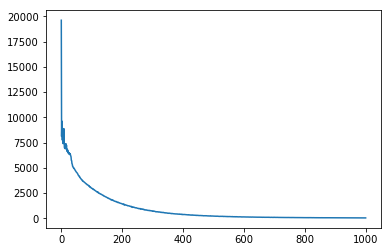

In [580]:
print(error[-2:])
plt.plot(error)


In [585]:
if __name__ == '__main__':
    r = RBM2(num_visible = 785, num_hidden = 500)
    training_data = np.array(images[:100])
    training_data=(training_data>0)*1
    training_data = np.insert(training_data, 0, 1, axis = 1)
    error_trace = r.train(training_data, max_epochs = 1000)


[19623.383223571316,
 8129.0961663901044,
 9721.811085904008,
 7903.7454343153577,
 7731.3634910732353,
 8980.8689120923191,
 7394.7867894375659,
 7595.175579593938,
 7647.0708677516141,
 8843.1018918027312,
 7070.2151553919921,
 7025.0601580131424,
 7091.1184149672999,
 7371.8568022573045,
 7162.0436803091052,
 7707.1998825426508,
 6692.4647827645213,
 6684.0463173001117,
 6686.5735966185684,
 6862.1652194272865,
 6621.7771557929918,
 6809.0595050597694,
 6603.9232432341332,
 6872.8747020344426,
 6700.2821691951103,
 6932.6066495052155,
 6793.3657463981226,
 6639.9081406732257,
 6569.2219876881109,
 6240.4531968572383,
 6106.6562827884454,
 5849.0339720228785,
 5778.6331672413089,
 5580.9578520872128,
 5572.7119370214532,
 5389.0826834681775,
 5449.0531408478673,
 5310.3593392882185,
 5306.8249075370786,
 5132.2392143935795,
 5096.0015531241461,
 4998.3257913535035,
 4915.9750815234156,
 4839.9383920920181,
 4791.8020609664445,
 4772.1823498007934,
 4768.8345606640769,
 4759.860646473

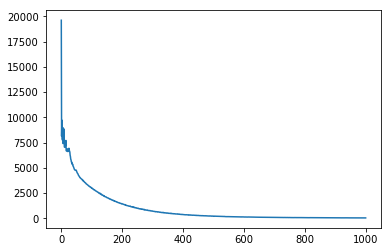

In [587]:
plt.plot(error_trace)
